In [36]:
%matplotlib inline
import pandas as pd
import numpy as np
from ast import literal_eval
from modAL.models import ActiveLearner
from functools import partial
from modAL.batch import uncertainty_batch_sampling

Load the dataset，convert the column "quality" to "good".

In [37]:
wine=pd.read_csv("winequality-red.csv")
wine.loc[wine['quality']>=7,'good']=1
wine.loc[wine['quality']<7,'good']=0

X represents independent variables.
y represents independent variable.

In [38]:
X= wine[wine.columns[0:11]]
y=wine['good']

In [39]:
# Set our RNG for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [40]:
X_raw = X.values
y_raw = y.values 

For visualization purposes, we apply PCA to the original dataset.

In [41]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)

This is how the dataset looks like.

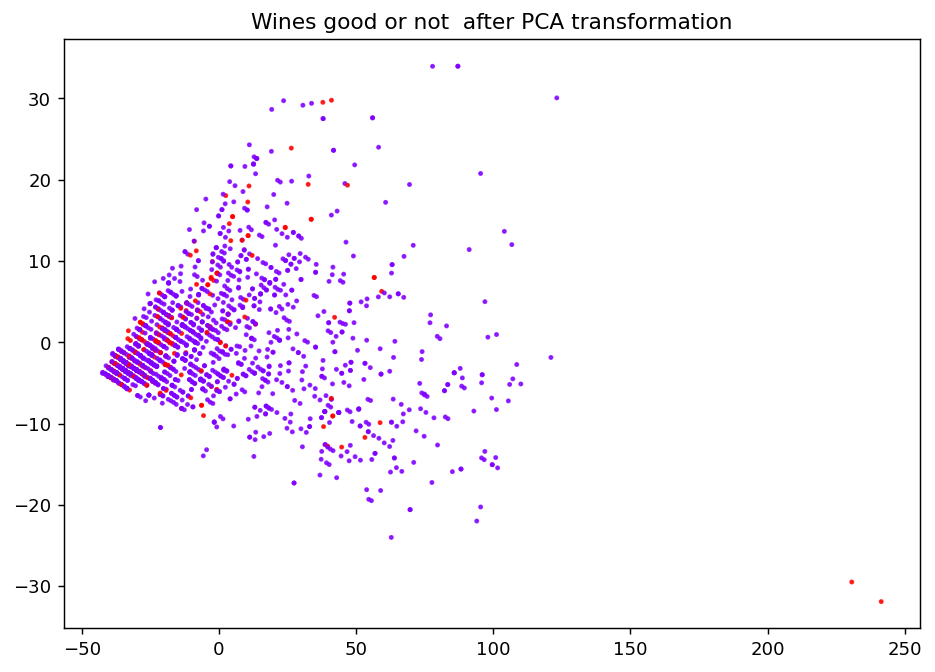

In [42]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='rainbow', s=3, alpha=8/10)
plt.title('Wines good or not  after PCA transformation')
plt.show()

Now we partition our dataset into a training set and an unlabeled pool.We first specify our training set consisting of 50 random examples. The remaining examples go to our “unlabeled” pool .

In [43]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=50)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

For the classification, we are going to use a simple k-nearest neighbors classifier.

In [44]:
from sklearn.neighbors import KNeighborsClassifier

# Specify our core estimator.
knn = KNeighborsClassifier(n_neighbors=5)

Now we initialize the ActiveLearner

In [45]:
from functools import partial
from modAL.batch import uncertainty_batch_sampling
from modAL.models import ActiveLearner

# Pre-set our batch sampling to retrieve 30 samples at a time.
BATCH_SIZE = 30
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)

# Specify our active learning model.
learner = ActiveLearner(
  estimator=knn,

  X_training=X_train,
  y_training=y_train,

  query_strategy=preset_batch
)

Let’s see how our classifier performs on the initial training set!

In [46]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

array([0., 0., 1., ..., 0., 0., 0.])

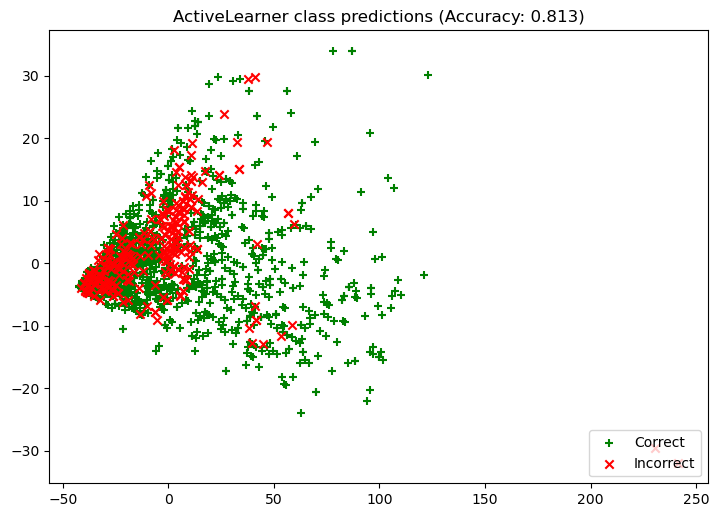

In [47]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=100)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct')
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect')
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

Now we Update our model by batch-mode sampling our “unlabeled” dataset . We tune our classifier by allowing it to query at most 450 instances it hasn’t seen before. To properly utilize batch-mode sampling, we allow our model to request 30 records per query and  subsequently allow our model to make 15 queries. Under the hood, our classifier aims to balance the ideas behind uncertainty and dissimilarity in its choices.

With each requested query, we remove that record from our pool and record our model’s accuracy on the raw dataset U

In [48]:
# Pool-based sampling
N_RAW_SAMPLES = 450
N_QUERIES = N_RAW_SAMPLES // BATCH_SIZE

performance_history = [unqueried_score]

for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool)

    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index], y_pool[query_index]
    learner.teach(X=X, y=y)

    # Remove the queried instance from the unlabeled pool.
    X_pool = np.delete(X_pool, query_index, axis=0)
    y_pool = np.delete(y_pool, query_index)

    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(X_raw, y_raw)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)

Accuracy after query 1: 0.8136
Accuracy after query 2: 0.8243
Accuracy after query 3: 0.8537
Accuracy after query 4: 0.8443
Accuracy after query 5: 0.8568
Accuracy after query 6: 0.8655
Accuracy after query 7: 0.8587
Accuracy after query 8: 0.8637
Accuracy after query 9: 0.8624
Accuracy after query 10: 0.8705
Accuracy after query 11: 0.8712
Accuracy after query 12: 0.8737
Accuracy after query 13: 0.8749
Accuracy after query 14: 0.8799
Accuracy after query 15: 0.8849


Evaluate our model’s performance

Here, we first plot the query iteration index against model accuracy. As you can see, this model is able to obtain an accuracy of ~0.88 within its first query, and isn’t as susceptible to getting “stuck” with querying uninformative records from our unlabeled set. To visualize the performance of our classifier, we also plot the correct and incorrect predictions on the full dataset.

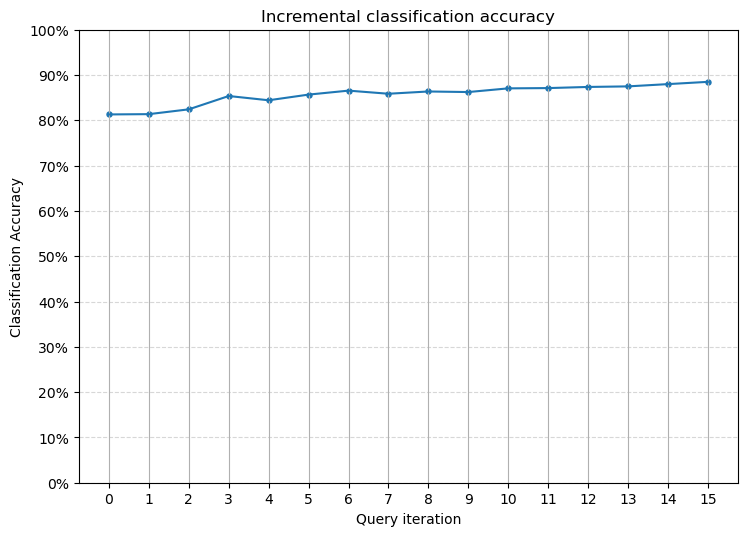

In [49]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=100)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=N_QUERIES + 30, integer=True))
ax.xaxis.grid(True)

ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.yaxis.grid(True, linestyle='--', alpha=1/2)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show() 

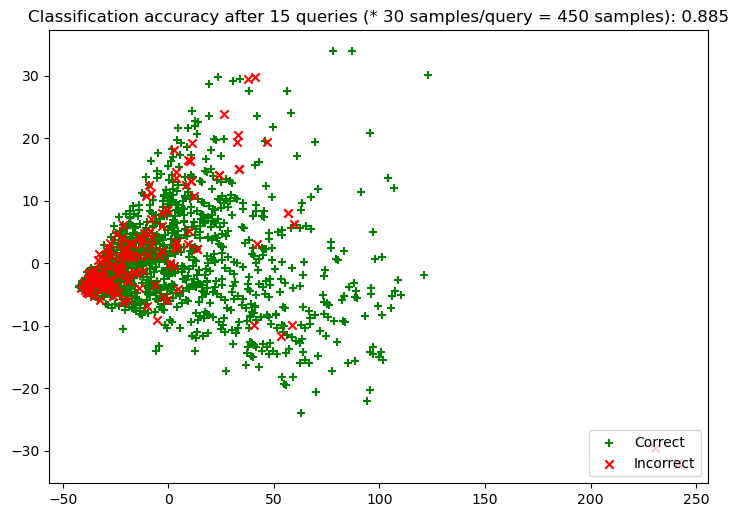

In [50]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=100)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct')
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect')

ax.set_title('Classification accuracy after {n} queries (* {batch_size} samples/query = {total} samples): {final_acc:.3f}'.format(
    n=N_QUERIES,
    batch_size=BATCH_SIZE,
    total=N_QUERIES * BATCH_SIZE,
    final_acc=performance_history[-1]
))
ax.legend(loc='lower right')

plt.show()

Now let's see how well knn with random sampling works.We can plot the AUC curve.

In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

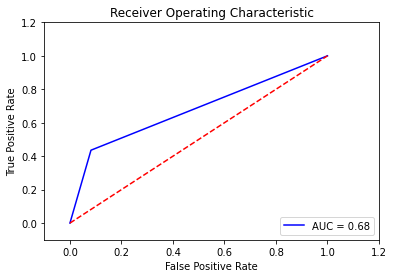

In [77]:
X=X
Y=y
#Train and Test Splitting
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.7,random_state=0)
scaler = StandardScaler()
X_train =scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

#Model and Training
knn = KNeighborsClassifier(n_neighbors=5)
y_pred = knn.fit(X_train, Y_train).predict(X_test)

#Model Evaluation
conf_mat = confusion_matrix(Y_test,y_pred)
acc = accuracy_score(Y_test,y_pred)
precision = precision_score(Y_test,y_pred)
recall = recall_score(Y_test,y_pred)
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [78]:
#Print Results
print('Confusion Matrix :')
print(conf_mat)
print('\nAccuracy is :')
print(acc)
print('\nPrecision is :')
print(precision)
print('\nRecall is: ')
print(recall)

Confusion Matrix :
[[900  80]
 [ 79  61]]

Accuracy is :
0.8580357142857142

Precision is :
0.4326241134751773

Recall is: 
0.4357142857142857


We can easily find that with the same size of training data(about 480 in total),active learning achieve higher accuracy and achieve farster.